In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os
from tqdm import tqdm
from mappings import get_element_mapping, get_item_mapping, get_area_mapping
from utils import load_dataframe, get_element_from_mapping, reshape_dataframe, percentage_of_total

In [4]:
dirname = os.getcwd() + '\data\production'

In [5]:
regions = load_dataframe(os.getcwd()+'\data\country_groups.csv')

In [10]:
population = load_dataframe(os.getcwd() + '\data\Population_E_All_Data_(Normalized).csv')

In [8]:
continents_list = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']
mask = ['economies' in regions.countrygroup[idx] for idx, val in enumerate(regions.countrygroup)]
economies_list = regions[mask].rename(columns = {'country':'area'})

In [9]:
files = os.listdir(dirname)
crops_processed = load_dataframe(dirname + "\\" + files[0])
crops = load_dataframe(dirname + "\\" + files[1])
indices = load_dataframe(dirname + "\\" + files[2])
livestock_primary = load_dataframe(dirname + "\\" + files[3])
livestock_processed = load_dataframe(dirname + "\\" + files[4])
livestock = load_dataframe(dirname + "\\" + files[5])

# Which data is important to our research

overall production quantities and production normalized over population per year should be looked into
different production crops / commodities require different amounts of fertilizer / water / resources and have different impacts on the environment, so separating items is a good idea until a further in-depth analysis of which item causes how much damage to the environment is done. 
Should not look at countries individually just for this unless we spot something weird.

# Data visualization

In [326]:
import geopandas as gpd
import geoplot
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

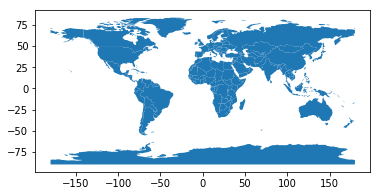

In [335]:
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).rename({'name':'area'},axis = 1)
world_map.plot()

## LIVESTOCK: Head counts

In [489]:
livestock[livestock.unit == 'No'].item.unique()
# for now lets not worry about this... 

array(['Beehives'], dtype=object)

In [565]:
# YEAR 2000 only, use widgets for interactivty for different years
livestock_map = livestock[(livestock.year == 2002)&(livestock.unit != 'No')]
livestock_map[livestock_map.unit == '1000 Head']['value'] = livestock_map[livestock_map.unit == '1000 Head']['value'].apply(lambda x: 1000*x)
# the line of code above is fugly, should check
livestock_map = livestock_map\
    .drop(['areacode', 'itemcode', 'elementcode', 'yearcode', 'year', 'flag'], axis = 1)\
    .merge(regions\
           .rename({'country':'area'}, axis = 1)\
           .drop(['countrygroupcode', 'countrygroup', 'countrycode', 'm49code', 'iso2code'], axis = 1), on = 'area')\
    .drop_duplicates()\
    .rename({'iso3code':'iso_a3'}, axis = 1)\
    .groupby(['iso_a3'])\
    .agg({'value':'sum'})\
    .rename({'value':'head_count'}, axis = 1)\
    .reset_index()

C:\Users\theop\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [566]:
livestock_map = world_map.merge(livestock_map, on = 'iso_a3')

Text(0.5, 1.0, 'Livestock Head Count per Country in 2002')

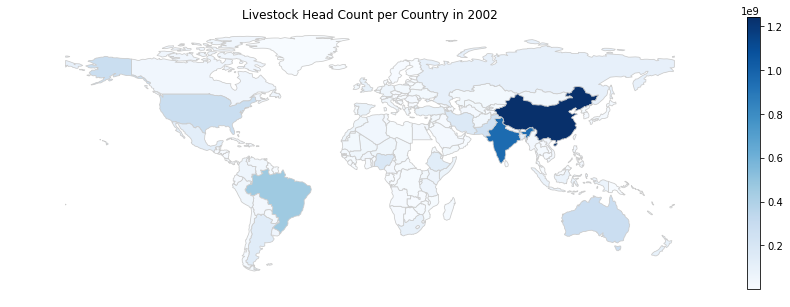

In [567]:
fig, ax = plt.subplots(figsize=(15,5))
livestock_map.plot(column='head_count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend = True)
ax.axis('off')
ax.set_title('Livestock Head Count per Country in 2002')
# this is not really representative of anything...

### Now repeat the plot but normalize by population!

In [569]:
population.unit.unique()

array(['1000 persons'], dtype=object)

In [570]:
pop_tot = population[(population.element == 'Total Population - Both sexes') & (population.year == 2002)]
pop_tot.value = pop_tot.value.apply(lambda x: x* 1000)
pop_tot = pop_tot.merge(regions.rename({'country':'area'}, axis = 1), on = 'area')\
    .drop(['areacode', 'itemcode', 'elementcode', 'yearcode', 'flag', \
           'note','countrygroupcode','countrycode', 'countrygroup', \
           'm49code', 'iso2code', 'item','unit','element', 'year', 'area'], axis = 1)\
    .rename({'value':'population', 'iso3code':'iso_a3'}, axis = 1)\
    .drop_duplicates()

livestock_map_norm = livestock_map.merge(pop_tot, on = 'iso_a3')

livestock_map_norm['head_count_per_pop'] = livestock_map_norm.apply(lambda x: x['head_count']/x['population'], axis = 1)

C:\Users\theop\Anaconda3\lib\site-packages\pandas\core\generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Text(0.5, 1.0, 'Livestock Head Count per Country per population in 2002')

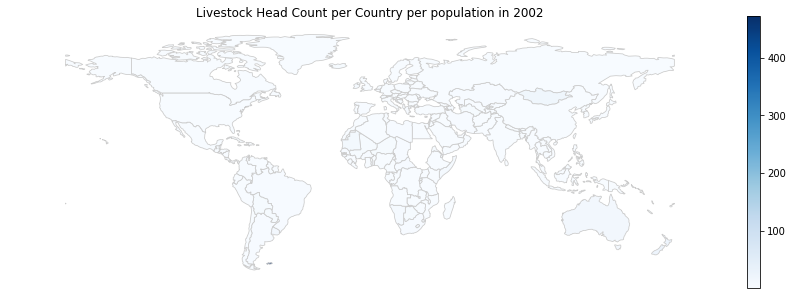

In [571]:
fig, ax = plt.subplots(figsize=(15,5))
livestock_map_norm.plot(column='head_count_per_pop', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend = True)
ax.axis('off')
ax.set_title('Livestock Head Count per Country per population in 2002')
# this is not really representative of anything...

## comparing all production for every csv df

In [131]:
crops_processed.element.unique()

array(['Production'], dtype=object)

In [132]:
crops.element.unique()
# for now just look at production?

array(['Area harvested', 'Yield', 'Production'], dtype=object)

In [133]:
indices.element.unique()
# will not look at this just now?

array(['Gross Production Index Number (2004-2006 = 100)',
       'Gross per capita Production Index Number (2004-2006 = 100)',
       'Net Production Index Number (2004-2006 = 100)',
       'Net per capita Production Index Number (2004-2006 = 100)'],
      dtype=object)

In [138]:
livestock_primary.element.unique()
# multiple elements for now just look at production?

array(['Laying', 'Yield', 'Production', 'Producing Animals/Slaughtered',
       'Yield/Carcass Weight', 'Milk Animals', 'Prod Popultn'],
      dtype=object)

In [137]:
livestock_processed.element.unique()
# 1 element straight forward

array(['Production'], dtype=object)

In [136]:
livestock.element.unique()
# 1 element straight forward

array(['Stocks'], dtype=object)

In [152]:
np.testing.assert_array_equal(crops_processed.columns, crops.columns)
np.testing.assert_array_equal(crops_processed.columns, indices.columns)
np.testing.assert_array_equal(crops_processed.columns, livestock_primary.columns)
np.testing.assert_array_equal(crops_processed.columns, livestock_processed.columns)
np.testing.assert_array_equal(crops_processed.columns, livestock.columns)

In [246]:
# get df select only production and select only world then value agg count then merge all df
prod1 = crops_processed[(crops_processed.area == 'World')&(crops_processed.element == 'Production')]\
        .groupby(['area', 'year', 'flag'])\
        .agg({'value':'sum'})\
        .reset_index().\
        rename({'value':'crops_processed'}, axis = 1)
prod2 = crops[(crops.area == 'World')&(crops.element == 'Production')]\
        .groupby(['area', 'year', 'flag'])\
        .agg({'value':'sum'})\
        .reset_index()\
        .rename({'value':'crops'}, axis = 1)
prod3 = livestock_primary[(livestock_primary.area == 'World')&(livestock_primary.element == 'Production')]\
        .groupby(['area', 'year', 'flag'])\
        .agg({'value':'sum'})\
        .reset_index()\
        .rename({'value':'livestock_primary'}, axis = 1)
prod4 = livestock_processed[(livestock_processed.area == 'World')&(livestock_processed.element == 'Production')]\
        .groupby(['area', 'year', 'flag'])\
        .agg({'value':'sum'})\
        .reset_index()\
        .rename({'value':'livestock_processed'}, axis = 1)
prod5 = livestock[(livestock.area == 'World')&(livestock.element == 'Stocks')]\
        .groupby(['area', 'year', 'flag'])\
        .agg({'value':'sum'})\
        .reset_index()\
        .rename({'value':'livestock'}, axis = 1)
prod_tot = prod1.merge(prod2, how = 'outer')\
    .merge(prod3, how = 'outer')\
    .merge(prod4, how = 'outer')\
    .merge(prod5, how = 'outer')\
    .melt(id_vars = ['area', 'year', 'flag'], var_name = 'total_production', value_name = 'value')

(1961, 2017)

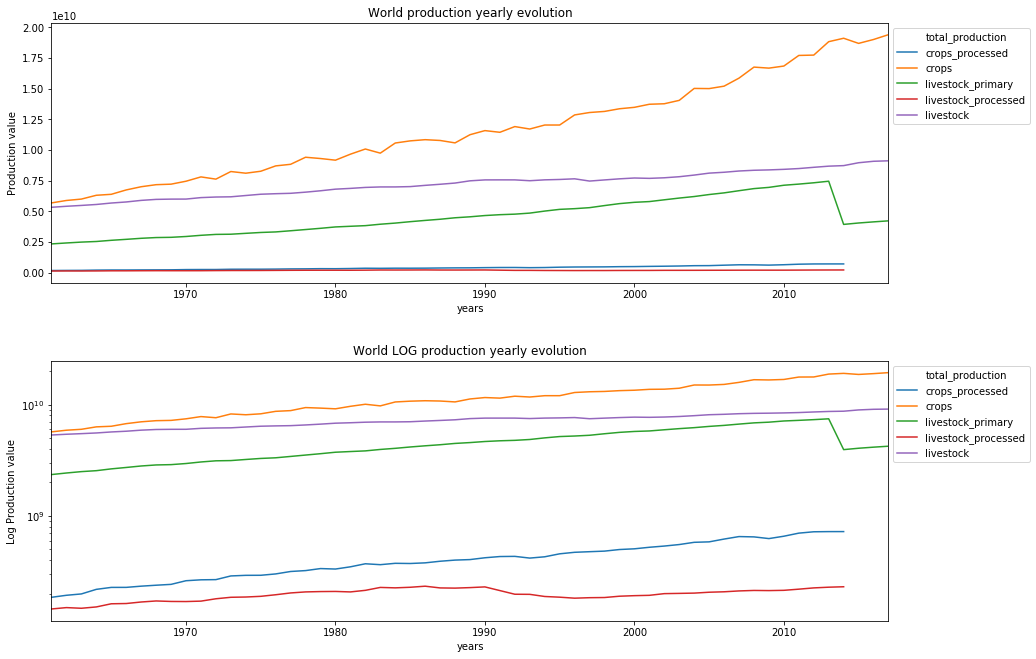

In [311]:
fig, ax = plt.subplots(figsize=(15,5 * 2 * 1.1), nrows = 2)
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
sns.lineplot(x= 'year', y = 'value' ,hue = 'total_production', data = prod_tot, ax = ax[0])
ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);
ax[0].set_title("World production yearly evolution")
ax[0].set_ylabel("Production value")
ax[0].set_yscale('linear')
ax[0].set_xlabel('years')
ax[0].set_xlim(left = 1961, right = 2017)


sns.lineplot(x= 'year', y = 'value' ,hue = 'total_production', data = prod_tot, ax = ax[1])
ax[1].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);
ax[1].set_title("World LOG production yearly evolution")
ax[1].set_ylabel("Log Production value")
ax[1].set_yscale('log')
ax[1].set_xlabel('years')
ax[1].set_xlim(left = 1961, right = 2017)

#### graph 
'production' is not defined for every category so this is just an overview... should ivnestigate livestock primary major drop in 2013... look at flags

Also this is not precise. Should look at categories separately:)

# Looking at each CSV in depth

# CROPS PROCESSED

In [12]:
crops_processed.item.unique()

array(['Cotton lint', 'Cottonseed', 'Molasses', 'Oil, cottonseed',
       'Oil, linseed', 'Oil, olive, virgin', 'Oil, sesame',
       'Oil, sunflower', 'Sugar Raw Centrifugal', 'Beer of barley',
       'Margarine, short', 'Oil, groundnut', 'Oil, palm', 'Oil, soybean',
       'Wine', 'Oil, rapeseed', 'Oil, safflower', 'Oil, coconut (copra)',
       'Oil, palm kernel', 'Palm kernels', 'Oil, maize'], dtype=object)

# CROPS

In [572]:
crops.element.unique()
# for now just look at production?

array(['Area harvested', 'Yield', 'Production'], dtype=object)

In [575]:
crops.unit.unique()

array(['ha', 'hg/ha', 'tonnes'], dtype=object)

In [621]:
#### strategy
crops_area = crops[crops.element == 'Area harvested']\
        .groupby(['area','year'])\
        .agg({'value':'sum'})\
        .rename({'value':'area_total'}, axis = 1)\
        .reset_index()\
        .merge(regions\
               .rename({'country':'area'}, axis= 1)\
               .drop(['countrygroupcode','countrygroup', 'countrycode','m49code','iso2code'], axis =1)\
               , on = 'area')\
        .drop_duplicates()\
        .rename({'iso3code':'iso_a3'}, axis = 1)\
       
crops_yield = crops[crops.element == 'Yield']\
        .groupby(['area','year'])\
        .agg({'value':'sum'})\
        .rename({'value':'yield_total'}, axis = 1)\
        .reset_index()\
        .merge(regions\
               .rename({'country':'area'}, axis = 1)\
               .drop(['countrygroupcode','countrygroup', 'countrycode','m49code','iso2code'], axis =1)\
               , on = 'area')\
        .drop_duplicates()\
        .rename({'iso3code':'iso_a3'}, axis = 1)\
       
crops_prod = crops[crops.element == 'Production']\
        .groupby(['area','year'])\
        .agg({'value':'sum'})\
        .rename({'value':'prod_total'}, axis = 1)\
        .reset_index()\
        .merge(regions\
               .rename({'country':'area'}, axis = 1)\
               .drop(['countrygroupcode','countrygroup', 'countrycode','m49code','iso2code'], axis =1)\
               , on = 'area')\
        .drop_duplicates()\
        .rename({'iso3code':'iso_a3'}, axis = 1)\
# should have unstacked it woulddve been easier
crops_tot = crops_area.merge(crops_yield, how = 'right').merge(crops_prod, how = 'right')
crops_tot = crops_tot[crops_tot.year == 2002]
merged = world_map.merge(crops_tot, on = 'iso_a3')


Text(0.5, 1.0, 'Total Crop area per Country in 2002')

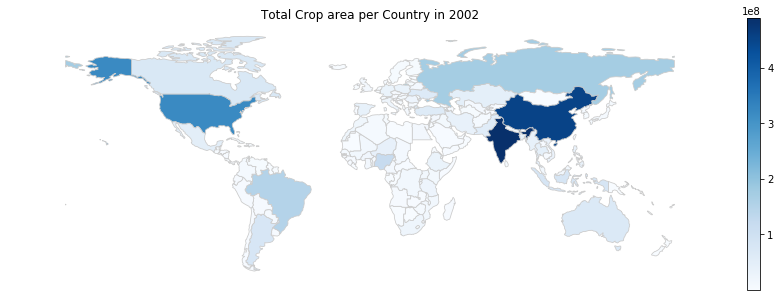

In [622]:
fig, ax = plt.subplots(figsize=(15,5))
merged.plot(column='area_total', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend = True)
ax.axis('off')
ax.set_title('Total Crop area per Country in 2002')
# this is not really representative of anything...

Text(0.5, 1.0, 'Total Crop Yield per Country in 2002')

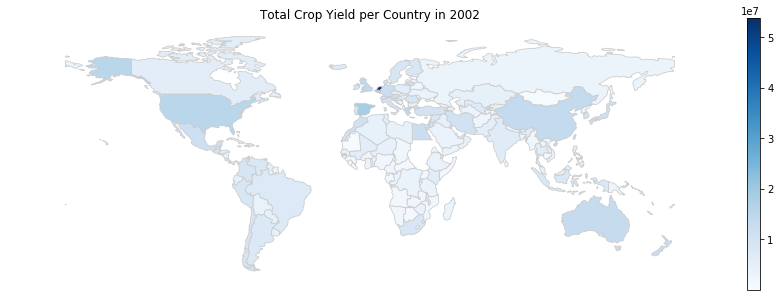

In [623]:
fig, ax = plt.subplots(figsize=(15,5))
merged.plot(column='yield_total', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend = True)
ax.axis('off')
ax.set_title('Total Crop Yield per Country in 2002')
# this is not really representative of anything...

Text(0.5, 1.0, 'Total Crop Production per Country in 2002')

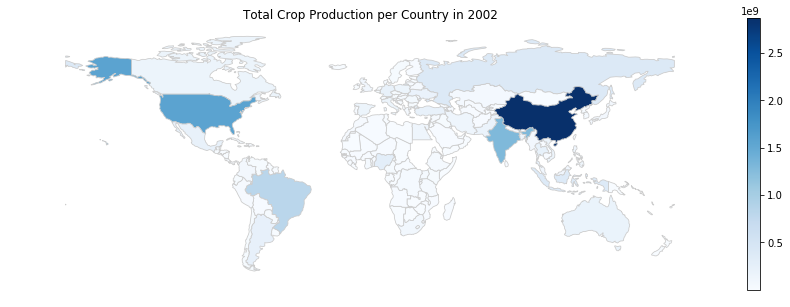

In [624]:
crops_tot = crops_area.merge(crops_yield, how = 'right').merge(crops_prod, how = 'right')
crops_tot = crops_tot[crops_tot.year == 2002]
merged = world_map.merge(crops_tot, on = 'iso_a3')

fig, ax = plt.subplots(figsize=(15,5))
merged.plot(column='prod_total', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend = True)
ax.axis('off')
ax.set_title('Total Crop Production per Country in 2002')
# this is not really representative of anything...

# LIVESTOCK PRIMARY

In [718]:
meat = livestock_primary[(livestock_primary.year == 2002)&(livestock_primary.item.str.contains('Meat')) & (livestock_primary.element == 'Production')]
meat.value[meat.unit == '1000 Head'] = meat.value.apply(lambda x: x * 1000)
meat = meat.groupby(['area', 'year', 'unit'])\
        .agg({'value':'sum'})\
        .reset_index()
meat_count = meat[meat.unit != 'tonnes'].drop('unit', axis = 1).rename({'value':'head_count'}, axis = 1)
meat_tonnes = meat[meat.unit == 'tonnes'].drop('unit', axis = 1).rename({'value':'tonnes'}, axis = 1)

C:\Users\theop\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [719]:
non_meat = livestock_primary[~(livestock_primary.item.str.contains('Meat'))&(livestock_primary.year == 2002)]
non_meat.item.unique()
# still need to group milk together, eggs together, skins and hides and hair and wool, then honey, and the rest
# also if we are going to analyze this we can merge it with the livestock_processed df...

array(['Eggs, hen, in shell', 'Eggs, hen, in shell (number)',
       'Hides, cattle, fresh', 'Honey, natural',
       'Milk, whole fresh camel', 'Milk, whole fresh cow',
       'Milk, whole fresh goat', 'Milk, whole fresh sheep',
       'Silk-worm cocoons, reelable', 'Skins, goat, fresh',
       'Skins, sheep, fresh', 'Wool, greasy', 'Eggs Primary',
       'Milk,Total', 'Eggs, other bird, in shell',
       'Eggs, other bird, in shell (number)', 'Milk, whole fresh buffalo',
       'Skins, sheep, with wool', 'Beeswax', 'Hides, buffalo, fresh',
       'Offals, nes', 'Snails, not sea', 'Hair, horse'], dtype=object)

In [720]:
meat_tonnes = meat_tonnes.merge(regions\
               .rename({'country':'area'}, axis = 1)\
               .drop(['countrygroupcode','countrygroup', 'countrycode','m49code','iso2code'], axis =1)\
               , on = 'area')\
        .drop_duplicates()\
        .rename({'iso3code':'iso_a3'}, axis = 1)

merged = world_map.merge(meat_tonnes, on = 'iso_a3')


Text(0.5, 1.0, 'Total tonnes of livestock per Country in 2002')

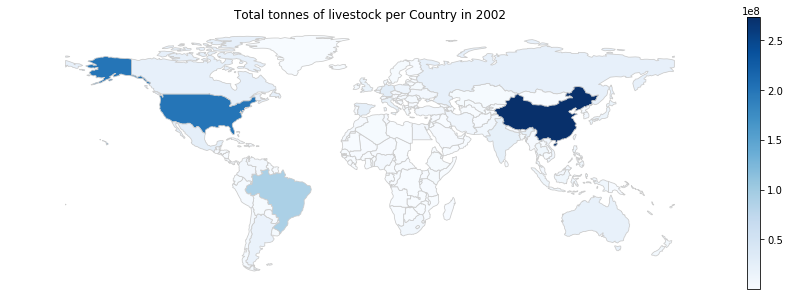

In [721]:
fig, ax = plt.subplots(figsize=(15,5))
merged.plot(column='tonnes', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend = True)
ax.axis('off')
ax.set_title('Total tonnes of livestock per Country in 2002')
# this is not really representative of anything...

# LIVESTOCK PROCESSED

In [728]:
livestock_processed.item.sort_values().unique()
# lets not worry about this for now
# should group milk together (and look at certain columns such as 'cheese all kind')

array(['Butter and Ghee', 'Butter and ghee, sheep milk',
       'Butter of goat mlk', 'Butter, buffalo milk', 'Butter, cow milk',
       'Cheese (All Kinds)', 'Cheese of goat mlk', 'Cheese, buffalo milk',
       'Cheese, sheep milk', 'Cheese, skimmed cow milk',
       'Cheese, whole cow milk', 'Cream fresh', 'Evaporat&Condensed Milk',
       'Ghee, butteroil of cow milk', 'Ghee, of buffalo milk', 'Lard',
       'Milk, dry buttermilk', 'Milk, skimmed condensed',
       'Milk, skimmed cow', 'Milk, skimmed dried',
       'Milk, skimmed evaporated', 'Milk, whole condensed',
       'Milk, whole dried', 'Milk, whole evaporated', 'Silk raw',
       'Skim Milk&Buttermilk,Dry', 'Tallow', 'Whey, condensed',
       'Whey, dry', 'Yoghurt'], dtype=object)

# LIVESTOCK

In [723]:
livestock.item.unique()
# we looked at this already

array(['Asses', 'Camels', 'Cattle', 'Chickens', 'Goats', 'Horses',
       'Mules', 'Sheep', 'Cattle and Buffaloes', 'Poultry Birds',
       'Sheep and Goats', 'Beehives', 'Buffaloes', 'Ducks',
       'Geese and guinea fowls', 'Pigs', 'Turkeys', 'Rabbits and hares',
       'Camelids, other', 'Rodents, other', 'Animals live nes',
       'Pigeons, other birds'], dtype=object)

# INDICES

In [724]:
indices.head()

,areacode,area,itemcode,item,elementcode,element,yearcode,year,unit,value,flag
0,2,Afghanistan,767,Cotton lint,432,Gross Production Index Number (2004-2006 = 100),1961,1961,Int. $,166.18,Fc
1,2,Afghanistan,767,Cotton lint,432,Gross Production Index Number (2004-2006 = 100),1962,1962,Int. $,254.15,Fc
2,2,Afghanistan,767,Cotton lint,432,Gross Production Index Number (2004-2006 = 100),1963,1963,Int. $,358.75,Fc
3,2,Afghanistan,767,Cotton lint,432,Gross Production Index Number (2004-2006 = 100),1964,1964,Int. $,254.15,Fc
4,2,Afghanistan,767,Cotton lint,432,Gross Production Index Number (2004-2006 = 100),1965,1965,Int. $,244.38,Fc


In [730]:
indices.item.sort_values().unique()
# PIN = production index number

array(['Agriculture (PIN)', 'Cereals,Total', 'Cotton lint', 'Cottonseed',
       'Crops (PIN)', 'Food (PIN)', 'Livestock (PIN)',
       'Meat indigenous, total', 'Milk,Total', 'Non Food (PIN)',
       'Oil, palm', 'Oilcrops, Oil Equivalent', 'Palm kernels',
       'Roots and Tubers,Total', 'Sugar, raw',
       'Vegetables and Fruit Primary'], dtype=object)

In [766]:
cont_pin = indices[(indices.item.str.contains('PIN')) & (indices.area.isin(continents_list))]\
    .drop(['areacode', 'itemcode','yearcode', 'elementcode', 'flag', 'unit'], axis = 1)\
    .groupby(['area', 'year', 'item']).agg({'value':'sum'}).reset_index().rename({'value':'USD'}, axis = 1)

In [768]:
cont_pin.area.unique()

array(['Africa', 'Americas', 'Asia', 'Europe', 'Oceania'], dtype=object)

In [791]:
africa = cont_pin[cont_pin.area == 'Africa']
america = cont_pin[cont_pin.area == 'Americas']
asia = cont_pin[cont_pin.area == 'Asia']
europe = cont_pin[cont_pin.area == 'Europe']
oceania = cont_pin[cont_pin.area == 'Oceania']

Text(0.5, 0, 'years')

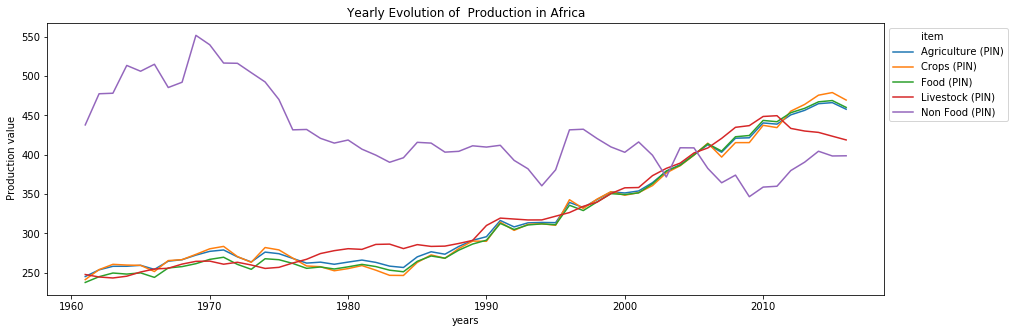

In [776]:
# should use widgets

fig, ax = plt.subplots( figsize = (15, 5))
sns.lineplot(x = 'year', y = 'USD', hue = 'item', data = africa, ax = ax)
ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', ncol = 1)
ax.set_title('Yearly Evolution of  Production in Africa')
ax.set_ylabel(" Production value")
# ax.set_yscale('log')
ax.set_xlabel('years')
# ax.set_xlim(left = 1961, right = 2014)
    
    
    

Text(0.5, 0, 'years')

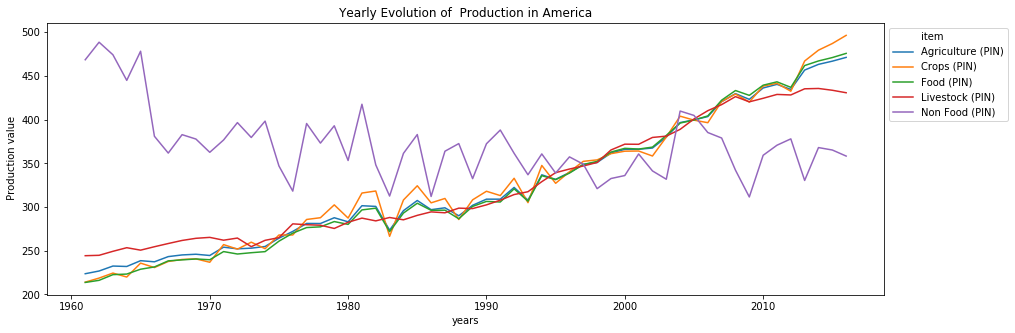

In [792]:
# should use widgets

fig, ax = plt.subplots( figsize = (15, 5))
sns.lineplot(x = 'year', y = 'USD', hue = 'item', data = america, ax = ax)
ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', ncol = 1)
ax.set_title('Yearly Evolution of  Production in America')
ax.set_ylabel(" Production value")
# ax.set_yscale('log')
ax.set_xlabel('years')
# ax.set_xlim(left = 1961, right = 2014)

Text(0.5, 0, 'years')

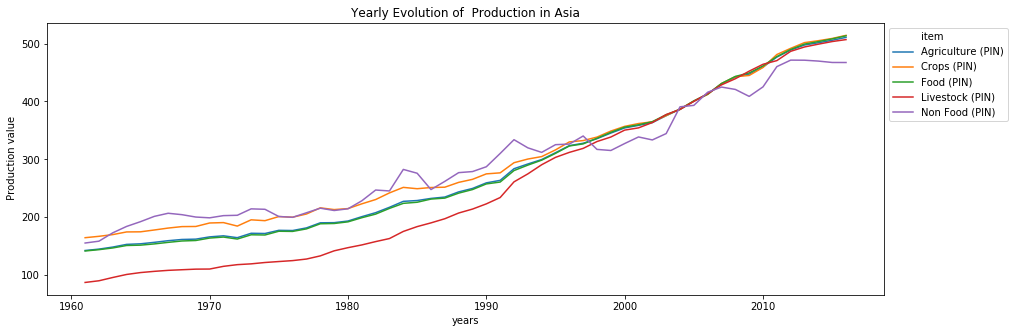

In [778]:
# should use widgets

fig, ax = plt.subplots( figsize = (15, 5))
sns.lineplot(x = 'year', y = 'USD', hue = 'item', data = asia, ax = ax)
ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', ncol = 1)
ax.set_title('Yearly Evolution of  Production in Asia')
ax.set_ylabel(" Production value")
# ax.set_yscale('log')
ax.set_xlabel('years')
# ax.set_xlim(left = 1961, right = 2014)
    
    
    

Text(0.5, 0, 'years')

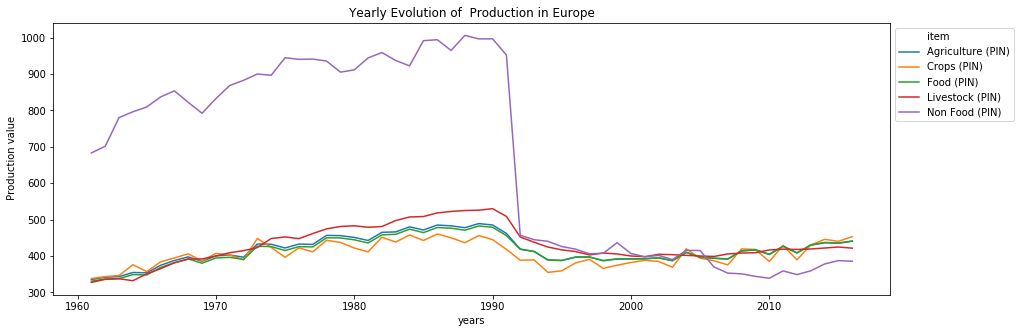

In [779]:
# should use widgets

fig, ax = plt.subplots( figsize = (15, 5))
sns.lineplot(x = 'year', y = 'USD', hue = 'item', data = europe, ax = ax)
ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', ncol = 1)
ax.set_title('Yearly Evolution of  Production in Europe')
ax.set_ylabel(" Production value")
# ax.set_yscale('log')
ax.set_xlabel('years')
# ax.set_xlim(left = 1961, right = 2014)
    
    
    

#### 1991.... something with USSR probably.... is russia part of Asia or Europe?

Text(0.5, 0, 'years')

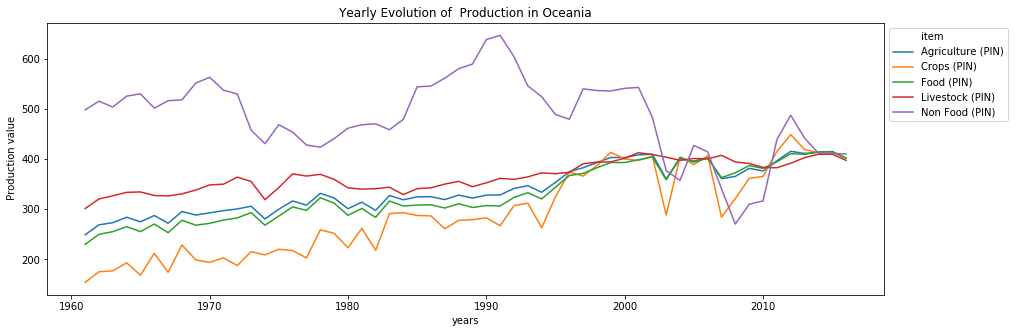

In [780]:
# should use widgets

fig, ax = plt.subplots( figsize = (15, 5))
sns.lineplot(x = 'year', y = 'USD', hue = 'item', data = oceania, ax = ax)
ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', ncol = 1)
ax.set_title('Yearly Evolution of  Production in Oceania')
ax.set_ylabel(" Production value")
# ax.set_yscale('log')
ax.set_xlabel('years')
# ax.set_xlim(left = 1961, right = 2014)
    
    
    